In [1]:

import QuantLib as ql
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functools import partial

ql_date = ql.Date("2023-01-11", "%Y-%m-%d") 
ql.Settings.instance().evaluationDate = ql_date

helpers = []

depositRates = 0.03218
depositMaturities =  "6M"
calendar = ql.TARGET()
fixingDays = 2
endOfMonth = False
convention = ql.ModifiedFollowing
dayCounter = ql.Actual360()

helpers.append(ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(depositRates)),
                ql.Period(depositMaturities), 
                fixingDays,
                calendar, 
                convention,
                endOfMonth,
                dayCounter))

bid_list= [3.51270, 3.45697, 3.29768, 3.18463, 3.10489, 3.06276, 3.03423,
3.00924, 2.99359, 2.97369, 2.94015, 2.87215, 2.76782, 2.54788]


ask_list = [3.53271, 3.48944, 3.33052, 3.21477, 3.13611, 3.09204, 3.06377,
3.03876, 3.01821, 3.00251, 2.96605, 2.90305, 2.79838, 2.57832]
mid = [(bid + ask)/2 for bid, ask in zip(bid_list,ask_list)]


fixedFrequency = ql.Annual
fixedConvention = ql.ModifiedFollowing
fixedDayCount = ql.Thirty360(ql.Thirty360.BondBasis)
calendar = ql.TARGET()

tenor =['1Y', '2Y', '3Y', '4Y', 
        '5Y', '6Y', '7Y', '8Y', 
        '9Y', '10Y', '12Y','15Y',
        '20Y', '30Y']
stibor_6m= ql.IborIndex('MyIndex', ql.Period('6M'), 0, ql.SEKCurrency(), calendar, ql.Following, True  , ql.Actual360())
for r,m in zip(mid, tenor):
    rate = ql.QuoteHandle(ql.SimpleQuote(r/100.0))
    tenor = ql.Period(m)
    swap_helper= ql.SwapRateHelper(rate, tenor, calendar, fixedFrequency, fixedConvention, fixedDayCount, stibor_6m)
    helpers.append(swap_helper)
    


In [2]:
curve1 = ql.PiecewiseLinearZero(0, ql.TARGET(), helpers, ql.Actual365Fixed())
dates, rates = zip(*curve1.nodes())

from typing import List
def ql_to_datetime(d: List[ql.Date]) -> List[datetime]:
    """
    Convert QUantLib.QuantLib.Date to datetime.
    """
    return datetime(d.year(), d.month(), d.dayOfMonth())
def calc_days(maturity: List[ql.Date], ql_date: datetime) -> List[datetime]:
    """
    Calculates the difference between maturity and start date for the curve. 
    """
    return  (maturity-ql_date).days

dates = list(map(ql_to_datetime, dates))
days = list(
    map(partial(calc_days,ql_date = datetime(2023,1,11)), dates)
    )
f = pd.DataFrame(dict({"Date": dates, "Rate": [depositRates*100] + [depositRates* 100] + mid,  "Zero Rate": rates, "Days" : days}))
f["Zero Rate"] = f["Zero Rate"]*100
f.iloc[1:, :]

,Date,Rate,Zero Rate,Days
1,2023-07-13,3.218000,3.236582,183
2,2024-01-11,3.522705,3.462077,365
3,2025-01-13,3.473205,3.408735,733
4,2026-01-12,3.314100,3.251694,1097
5,2027-01-11,3.199700,3.137876,1461
6,2028-01-11,3.120500,3.058762,1826
7,2029-01-11,3.077400,3.014758,2192
8,2030-01-11,3.049000,2.987021,2557
9,2031-01-13,3.024000,2.962233,2924
10,2032-01-12,3.005900,2.944384,3288


In [3]:
table = f.iloc[1:, :].copy()
table.loc[:, "Date"] = table.loc[:, "Date"].apply(lambda x : x.strftime("%Y-%m-%d"))
table.drop(columns = "Days", inplace=True)
table.rename(columns = {"Zero Rate": "QuantLib Zero Rate"}, inplace = True)
table["Bloomberg Zero Rates"] = [3.23658, 3.46207, 3.40873, 3.25169, 
                                 3.13788, 3.05876, 3.01476, 2.98702,
                                 2.96223, 2.94438, 2.92562,
                                 2.88943, 2.81743, 2.69882, 2.43391]
table["Basis Point Difference"] = 10000 *(table["Bloomberg Zero Rates"] - table["QuantLib Zero Rate"])
print(table.iloc[:, :].to_markdown())

|    | Date       |    Rate |   QuantLib Zero Rate |   Bloomberg Zero Rates |   Basis Point Difference |
|---:|:-----------|--------:|---------------------:|-----------------------:|-------------------------:|
|  1 | 2023-07-13 | 3.218   |              3.23658 |                3.23658 |              -0.015275   |
|  2 | 2024-01-11 | 3.52271 |              3.46208 |                3.46207 |              -0.0746395  |
|  3 | 2025-01-13 | 3.47321 |              3.40873 |                3.40873 |              -0.04655    |
|  4 | 2026-01-12 | 3.3141  |              3.25169 |                3.25169 |              -0.0397416  |
|  5 | 2027-01-11 | 3.1997  |              3.13788 |                3.13788 |               0.038115   |
|  6 | 2028-01-11 | 3.1205  |              3.05876 |                3.05876 |              -0.0230695  |
|  7 | 2029-01-11 | 3.0774  |              3.01476 |                3.01476 |               0.0163274  |
|  8 | 2030-01-11 | 3.049   |              2.98702 |   

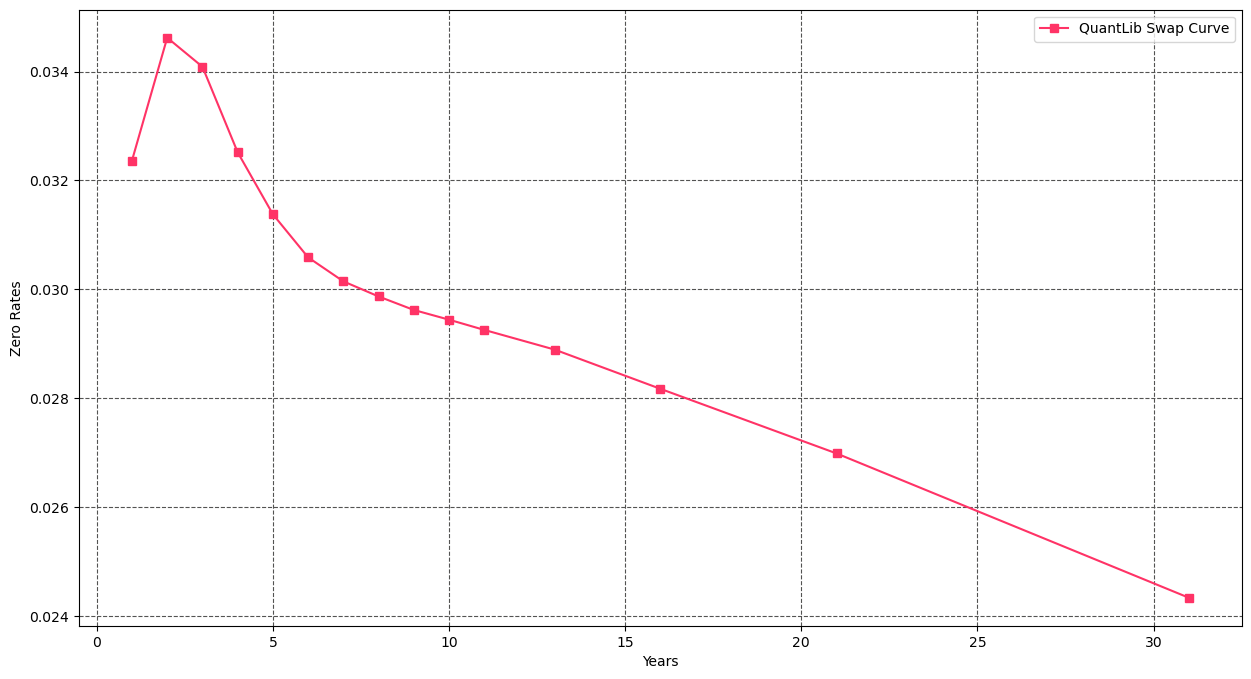

In [4]:
CB91_Blue = '#2CBDFE'
fig, ax = plt.subplots(figsize = (15,8))
ax.plot([date.year - 2022 for date in dates[1:]], rates[1:], marker = 's', label = "QuantLib Swap Curve", color= "#ff3366")
ax.grid("on", linestyle = "--", c = '#535352')
ax.set_ylabel("Zero Rates")
ax.set_xlabel("Years")
ax.legend()
plt.savefig("quantlib_res.png", dpi = 1200, bbox_inches='tight')